In [269]:
import random
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import glob
import pickle
from tqdm import tqdm
import cv2

%matplotlib inline

In [270]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torchvision import transforms

from torch.utils.data import Dataset

In [271]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(device)

cpu


In [272]:
img_list = sorted(glob.glob("archive/PNGImages/*.png"))
label_list = sorted(glob.glob("archive/PedMasks/*.png"))
assert len(img_list) == len(label_list)
print ("Collected {} images".format(len(img_list)))

Collected 170 images


### Check whether the data is read successfully

Text(0.5, 1.0, 'Masked Image')

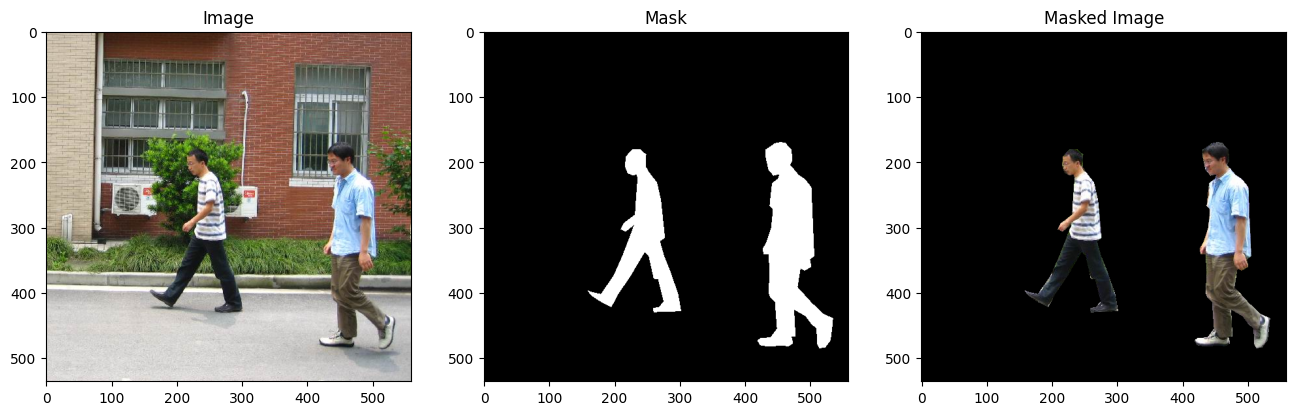

In [273]:
img = cv2.imread(img_list[0])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
mask = cv2.imread(label_list[0],cv2.IMREAD_GRAYSCALE)

mask = mask > 0

plt.figure(figsize = (16,48))
plt.subplot(1,3,1)
plt.imshow(img)
plt.title('Image')
plt.subplot(1,3,2)
plt.imshow(mask,cmap='gray')
plt.title('Mask')
plt.subplot(1,3,3)
plt.imshow((img*mask[:,:,None]))
plt.title('Masked Image')


### (a)  Cut the FudanPed dataset into an 80-10-10 train-val-test split

In [274]:
from random import shuffle

def shuffle_two_lists(listA, listB):
    temp = list(zip(listA, listB))
    shuffle(temp)
    return zip(*temp)

train_split_ratio = 0.8
test_split_ratio = 0.1

num_samples = len(img_list)
train_size = int(num_samples*train_split_ratio)
test_size = int(num_samples*test_split_ratio)
val_size = num_samples-train_size-test_size

img_list_shuffled, label_list_shuffled = shuffle_two_lists(img_list, label_list)

train_img_list, train_label_list = img_list_shuffled[:train_size], label_list_shuffled[:train_size]
val_img_list, val_label_list = img_list_shuffled[train_size:train_size+val_size], label_list_shuffled[train_size:train_size+val_size]
test_img_list, test_label_list = img_list_shuffled[train_size+val_size:], label_list_shuffled[train_size+val_size:]

print ("Training set size: {}".format(len(train_img_list)))
print ("Validation set size: {}".format(len(val_img_list)))
print ("Test set size: {}".format(len(test_img_list)))

Training set size: 136
Validation set size: 17
Test set size: 17


### (b) data agumentation includes data preprocess, random scaling and random flipping.

In [275]:
class PedDataset(Dataset):
    def __init__(self, img_path_list, label_path_list, 
                     res=(96,96), IF_TRAIN=False):
        self.img_path_list = img_path_list
        self.label_path_list = label_path_list
        self.res = res
        self.IF_TRAIN = IF_TRAIN
        self.scale_factor = 0.1
        
        self.img_list, self.mask_list = self.preprocess()
        
    def __len__(self):
        return len(self.img_list)

    def preprocess(self):
        img_list  = []
        mask_list = []
        for idx in tqdm(range(len(self.label_path_list))):
            img = cv2.imread(self.img_path_list[idx])
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            mask = cv2.imread(self.label_path_list[idx], cv2.IMREAD_GRAYSCALE)
            mask[mask>=1] = 255
            
            img = cv2.resize(img, self.res)
            mask = cv2.resize(mask, self.res)
            
            img_list.append(img)
            mask_list.append(mask)
        return img_list, mask_list
                    
                    
    def __getitem__(self, idx):
        img = self.img_list[idx]
        mask = self.mask_list[idx]
        
        # randonm agumentation
        if self.IF_TRAIN:
            if random.random()<0.7:
                scaler = np.random.randn()*self.scale_factor+1
                new_res = (int(self.res[0]*scaler), int(self.res[1]*scaler))
                img_candidate = cv2.resize(img, new_res)
                mask_candidate = cv2.resize(mask, new_res)
                if scaler >= 1:
                    x_begin = (new_res[0]-self.res[0])//2
                    y_begin = (new_res[1]-self.res[1])//2
                    img = img_candidate[x_begin:x_begin+self.res[0],y_begin:y_begin+self.res[1]]
                    mask = mask_candidate[x_begin:x_begin+self.res[0],y_begin:y_begin+self.res[1]]
                else:
                    img = np.zeros_like(img)
                    mask = np.zeros_like(mask)
                    x_begin = (self.res[0]-new_res[0])//2
                    y_begin = (self.res[1]-new_res[1])//2
                    img[x_begin:x_begin+new_res[0],y_begin:y_begin+new_res[1]] = img_candidate
                    mask[x_begin:x_begin+new_res[0],y_begin:y_begin+new_res[1]] = mask_candidate
            
            
            if random.random()<0.5:
                img = np.array(img[:,::-1,:])
                mask = np.array(mask[:,::-1])
                                
        img = torch.Tensor(img).permute(2,0,1)        
        label = torch.Tensor(mask).unsqueeze(0)
        
        return img/255., label/255.  

### Example of the data augmentation

100%|██████████| 170/170 [00:00<00:00, 223.03it/s]


Text(0.5, 1.0, 'Masked Image')

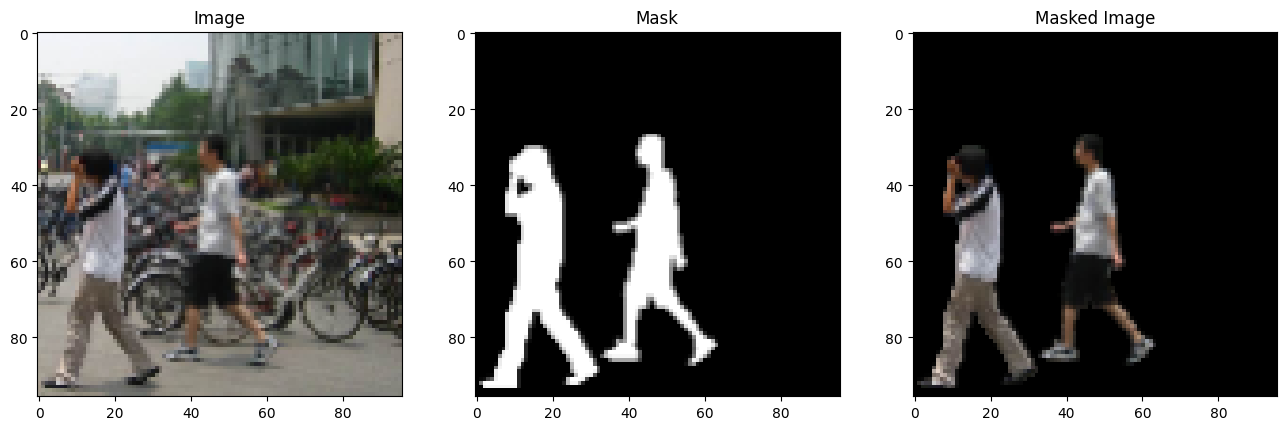

In [276]:
dataset = PedDataset(img_list, label_list, IF_TRAIN=True)
img, label = dataset[8]
img = img.permute(1,2,0)
label = label.permute(1,2,0)
plt.figure(figsize = (16,48))
plt.subplot(1,3,1)
plt.imshow(img.cpu().numpy())
plt.title('Image')
plt.subplot(1,3,2)
plt.imshow(label.squeeze(),cmap='gray')
plt.title('Mask')
plt.subplot(1,3,3)
plt.imshow((img*label).cpu().numpy())
plt.title('Masked Image')

### (c) Implement and train a CNN

In [277]:
# define single_conv layer
class single_conv(nn.Module):
    '''Conv2d + BatchNorm2d + ReLu'''
    def __init__(self, input_channel, output_channel):
        super(single_conv, self).__init__()
        # Conv2d.  Use padding of (1,1) to maintain the size.
        self.conv = nn.Conv2d(input_channel, output_channel, 3, stride=1, padding=1)
        # BatchNorm2d
        self.bn = nn.BatchNorm2d(output_channel)
        # ReLu
        self.relu = nn.ReLU(inplace=True)

        
    def forward(self, x):
        # use the layers above
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x


# define down layer
class down_layer(nn.Module):
    def __init__(self):
        super(down_layer, self).__init__()
        # downsample by a factor of 2
        self.down = nn.MaxPool2d(2) 
        
    def forward(self, x):
        x = self.down(x)
        return x


# define up layer
class up_layer(nn.Module):
    def __init__(self):
        super(up_layer, self).__init__()       
        self.up = nn.Upsample(scale_factor=2, mode='bilinear') # use nn.Upsample() with mode bilinear
        
    # concatenate with previously saved feature x2
    def forward(self, x1, x2): # smaller x1 and larger x2
        # upsample x1 to be same size as x2
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2])
        # concatenat x2 and x1 in channel dimension
        # tensor shape : (batchsize, channel, x_dim, y_dim)
        x = torch.cat([x2, x1], dim=1)
        return x


# define outconv layer
class outconv(nn.Module):
    def __init__(self, input_channel, output_channel):
        super(outconv, self).__init__()
        # 1 Conv2d layer
        self.conv = nn.Conv2d(input_channel, output_channel, 3, stride=1, padding=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # forward Conv2d layer + sigmoid
        x = self.conv(x)
        x = self.sigmoid(x)
        return x

### network architecture

In [278]:
# Conv2d + BatchNorm2d + ReLu
# follow the U-Net structure shown as the requirements.
class UNet(nn.Module):
    def __init__(self, n_channels_in, n_channels_out):
        super(UNet, self).__init__()
        self.conv1 = single_conv(n_channels_in, 16)
        self.conv2 = single_conv(16, 16)
        self.down1 = down_layer()

        self.conv3 = single_conv(16, 32)
        self.conv4 = single_conv(32, 32)
        self.down2 = down_layer() 

        self.conv5 = single_conv(32, 32)
        self.conv6 = single_conv(32, 32)
        self.up1 = up_layer()

        self.conv7 = single_conv(64, 16)
        self.conv8 = single_conv(16, 16)
        self.up2 = up_layer()

        self.conv9 = single_conv(32, 16)
        self.conv10 = single_conv(16, 16)
        self.outconv = outconv(16, n_channels_out)


    def forward(self, x):
        # define forward pass
        ## go to the lower
        x1 = self.conv1(x)
        x1 = self.conv2(x1)
        x1_downsample = self.down1(x1)

        x2 = self.conv3(x1_downsample)
        x2 = self.conv4(x2)
        x2_downsample = self.down2(x2)
        
        x3 = self.conv5(x2_downsample)
        x3 = self.conv6(x3)
        x3_upsample = self.up1(x3, x2)
        
        ## go to the upper
        x4 = self.conv7(x3_upsample)
        x4 = self.conv8(x4)
        x4_upsample = self.up2(x4, x1)

        x5 = self.conv9(x4_upsample)
        x5 = self.conv10(x5)
        x = self.outconv(x5)
        return x  

In [279]:
# define dice value (evaluation func)
def cal_dice(pred_value, real_value):
    e = 1
    batch_size = pred_value.size(0)
    a1 = pred_value.view(batch_size, -1).float() 
    a2 = real_value.view(batch_size, -1).float() 
    up_value = sum(a1*a2)
    down_value = sum(a1) + sum(a2)
    # calculate the dice value
    dice = (2*up_value + e) / (down_value + e)
    return dice.mean()


### loss function

In [280]:
# define the value of 1 - softdice (loss fun)
class softdice_loss(nn.Module):
    def __init__(self, e = 1):
        super(softdice_loss, self).__init__()
        self.e = e
        
    def forward(self, pred, target):
        num = pred.size(0)
        a1 = pred.view(num, -1).float()  # Flatten
        a2 = target.view(num, -1).float()  # Flatten
        up_value = sum(a1*a2)
        down_value = sum(a1*a1) + sum(a2*a2)
        softdice = (2*up_value + self.e) / (down_value + self.e)
        loss = 1 - softdice
        return loss.mean()

In [281]:
# generate train,validation,and test datasets
train_dataset = PedDataset(train_img_list, train_label_list, IF_TRAIN=True)
val_dataset = PedDataset(val_img_list, val_label_list, IF_TRAIN=True)
test_dataset = PedDataset(test_img_list, test_label_list, IF_TRAIN=True)

100%|██████████| 17/17 [00:00<00:00, 210.30it/s]


### training hyper-parameter excptes the SAVE_PATH

In [282]:
# define parameters (epochs, batch size and learning rate)

NUM_EPOCHS = 40 
batchsize = 8 
learning_rate = 0.001 
SAVE_PATH = "./UNET_MODEL/"

# Comment: 
My network architecture: U-net. <br>
Loss func: soft dice loss function.<br>
Training hyper-parameter: learning rate, epoch, batch size.<br>

In [283]:
# load data

train_loader = torch.utils.data.DataLoader(train_dataset, 
                                           batch_size= batchsize, 
                                           shuffle=True, 
                                           num_workers=0)
val_loader = torch.utils.data.DataLoader(val_dataset, 
                                         batch_size= batchsize, 
                                         shuffle=False, 
                                         num_workers=0)
test_loader = torch.utils.data.DataLoader(test_dataset, 
                                         batch_size= batchsize, 
                                         shuffle=False, 
                                         num_workers=0)
                                         

In [284]:
def train_epoch(net, data_loader, optimizer, criterion, epoch):   
    net = net.train()
    loss_stat = []
    for i, img_mask in enumerate(data_loader):
        img, mask = img_mask
        img = img.to(device)
        mask = mask.to(device)
        pred_lable = net(img)
        optimizer.zero_grad() # set gradient 0
        loss = criterion(pred_lable, mask)
        loss_stat += [loss.item()]*img.shape[0]
        loss.backward() # calculate gradient
        optimizer.step() #update parameters
    
    print ("Epoch {}: [{}/{}] Loss: {:.3f}".format(epoch, len(data_loader), len(data_loader),np.mean(loss_stat))) 
    
    return np.mean(loss_stat)

In [285]:
def eval_epoch(net, data_loader, metric, criterion, epoch):
    net = net.eval()

    metric_stat = []
    val_loss_stat = []
    for i, img_mask in enumerate(data_loader):
        img, mask = img_mask
        img = img.to(device)
        mask = mask.to(device)
        
        with torch.no_grad(): # do not compute gradient
            pred = net(img)
            val_loss = criterion(pred, mask)
            
        pred = pred>0.5 # Convert probability to prediction mask
        dice = metric(pred, mask)
        metric_stat += [dice.item()]*img.shape[0]
        val_loss_stat += [val_loss.item()]*img.shape[0]
        
    print ("Dice: {:.3f}  Val Loss: {:.3f} ".format(np.mean(metric_stat), np.mean(val_loss_stat)))
    
    return np.mean(metric_stat), np.mean(val_loss_stat)

In [286]:
net = UNet(3,1)
net.to(device)  
print(net)

n_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
print('Number of parameters in network: ', n_params)

UNet(
  (conv1): single_conv(
    (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
  )
  (conv2): single_conv(
    (conv): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
  )
  (down1): down_layer(
    (down): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): single_conv(
    (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
  )
  (conv4): single_conv(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (rel

In [287]:
optimizer = optim.Adam(net.parameters(), lr = learning_rate)

criterion = softdice_loss()

train_loss_list = []
val_loss_list = []
val_dice_list = []
# Start training
for epoch in range(NUM_EPOCHS):    
    loss = train_epoch(net, train_loader, optimizer, criterion, epoch)
    val_dice, val_loss = eval_epoch(net, val_loader, cal_dice, criterion, epoch)
    
    # Record losses and validation dice for each epoch
    train_loss_list.append(loss)
    val_loss_list.append(val_loss)
    val_dice_list.append(val_dice)
    
    # Save the model after each epoch
    if os.path.isdir(SAVE_PATH):
        torch.save(net.state_dict(),SAVE_PATH + 'PedSegEpoch{}.pth'.format(epoch + 1))
    else:
        os.makedirs(SAVE_PATH, exist_ok=True)
        torch.save(net.state_dict(),SAVE_PATH + 'PedSegEpoch{}.pth'.format(epoch + 1))
    print('Checkpoint {} saved to {}'.format(epoch + 1, SAVE_PATH + 'PedSegEpoch{}.pth'.format(epoch + 1)))   

Epoch 0: [17/17] Loss: 0.400
Dice: 0.600  Val Loss: 0.385 
Checkpoint 1 saved to ./UNET_MODEL/PedSegEpoch1.pth
Epoch 1: [17/17] Loss: 0.253
Dice: 0.598  Val Loss: 0.301 
Checkpoint 2 saved to ./UNET_MODEL/PedSegEpoch2.pth
Epoch 2: [17/17] Loss: 0.217
Dice: 0.719  Val Loss: 0.234 
Checkpoint 3 saved to ./UNET_MODEL/PedSegEpoch3.pth
Epoch 3: [17/17] Loss: 0.196
Dice: 0.759  Val Loss: 0.186 
Checkpoint 4 saved to ./UNET_MODEL/PedSegEpoch4.pth
Epoch 4: [17/17] Loss: 0.176
Dice: 0.761  Val Loss: 0.180 
Checkpoint 5 saved to ./UNET_MODEL/PedSegEpoch5.pth
Epoch 5: [17/17] Loss: 0.158
Dice: 0.794  Val Loss: 0.153 
Checkpoint 6 saved to ./UNET_MODEL/PedSegEpoch6.pth
Epoch 6: [17/17] Loss: 0.158
Dice: 0.798  Val Loss: 0.149 
Checkpoint 7 saved to ./UNET_MODEL/PedSegEpoch7.pth
Epoch 7: [17/17] Loss: 0.148
Dice: 0.779  Val Loss: 0.176 
Checkpoint 8 saved to ./UNET_MODEL/PedSegEpoch8.pth
Epoch 8: [17/17] Loss: 0.144
Dice: 0.758  Val Loss: 0.179 
Checkpoint 9 saved to ./UNET_MODEL/PedSegEpoch9.pth
E

### (d)  training loss, validation loss, and validation DICE curve

[]

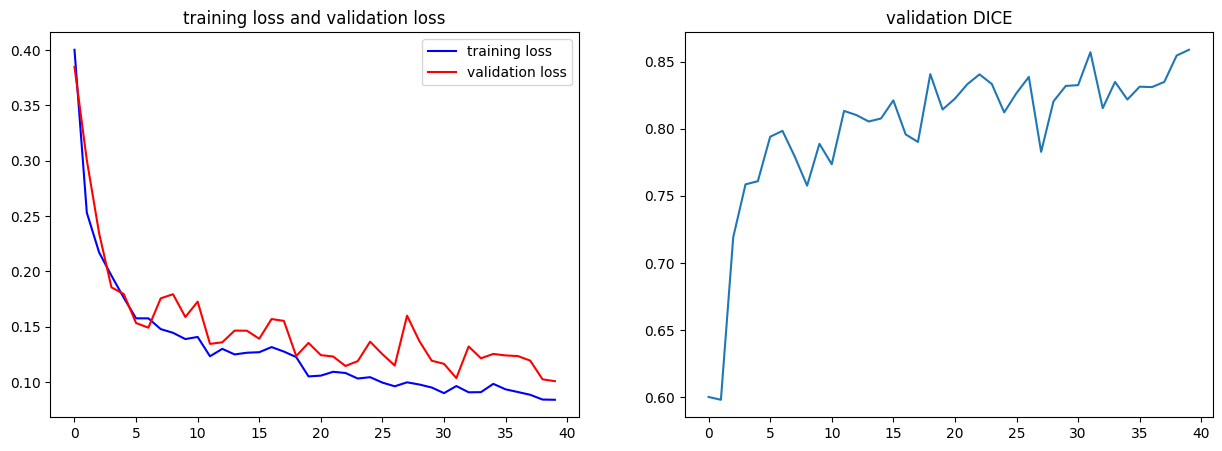

In [288]:
# Plot training loss and validation loss
plt.figure(figsize = (15,5))
plt.subplot(1,2,1)
plt.plot(train_loss_list, color = "b", label = 'training loss')
plt.legend()
plt.plot(val_loss_list, color = 'red', label = 'validation loss')
plt.legend()
plt.title('training loss and validation loss')
plt.subplot(1,2,2)
plt.plot(val_dice_list)
plt.title('validation DICE')

plt.plot()


# Comment: 
Overall, it is no overfitting. Specifically, the train loss is greater than the validation loss at a small number of points, the validation loss is greater than the train loss at a large number of points, and these two loss values show decreasing trend.

# (e)  For test-set, achieve a score of around 0.7 or better

In [289]:
test_dice, test_loss = eval_epoch(net, test_loader, cal_dice, criterion, NUM_EPOCHS)

Dice: 0.844  Val Loss: 0.115 


# Comment:  
the average dice score is better than 0.7

### prediction function

In [290]:
def predict_mask(net, img, res, out_threshold=0.5):
    # set the mode of your network to evaluation
    net.eval()

    
    img = cv2.resize(img, res)
    img = torch.Tensor(img).permute(2,0,1).unsqueeze(0)/255
    img = img.to(device)

    with torch.no_grad():
        
        # predict the masks 
        pred = net(img)
        pred = pred.squeeze(0).squeeze(0)
        #  use threshold p = 0.5 to o decide if a pedestrian is at the pixel location or not
        pred = (pred > out_threshold).byte()
    return pred

### (f)  3 example segmentations  from the training data

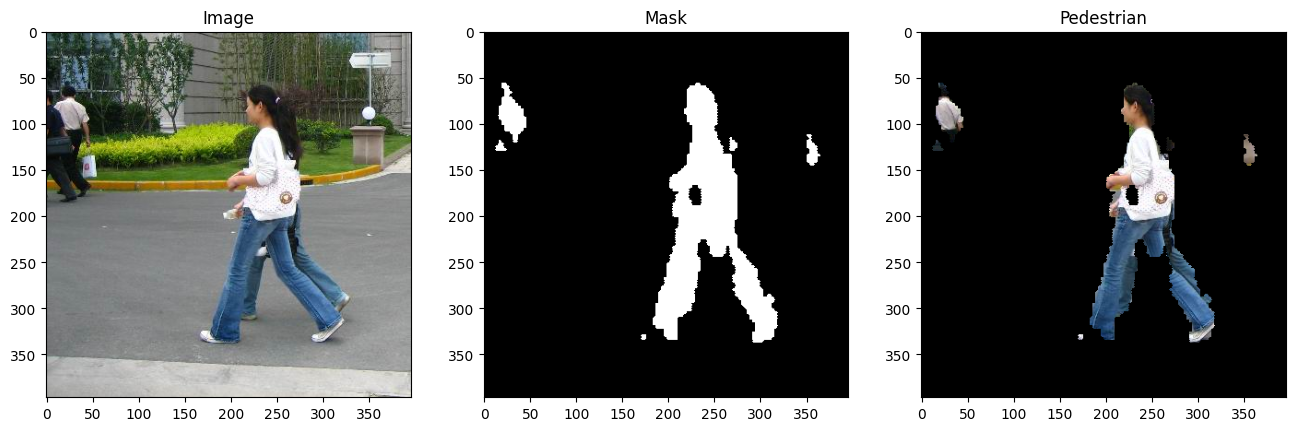

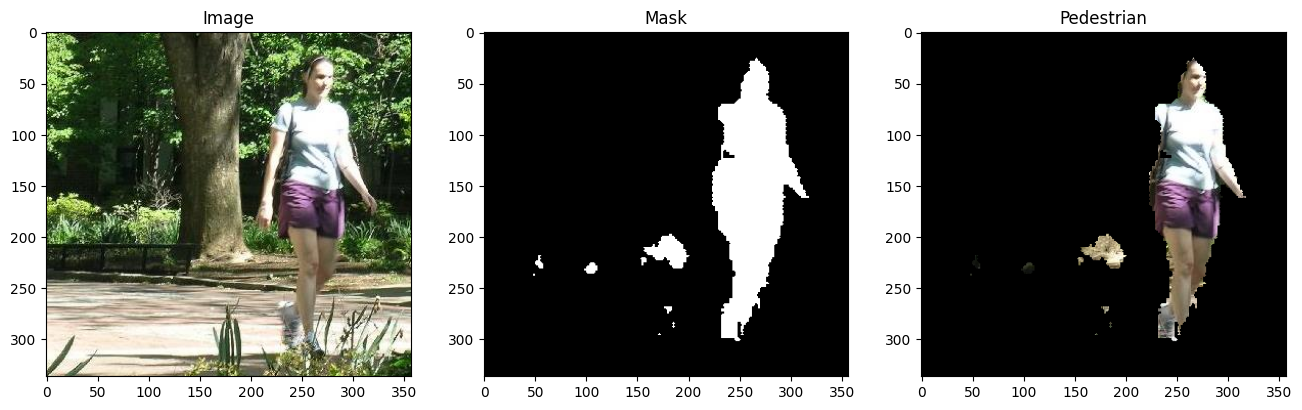

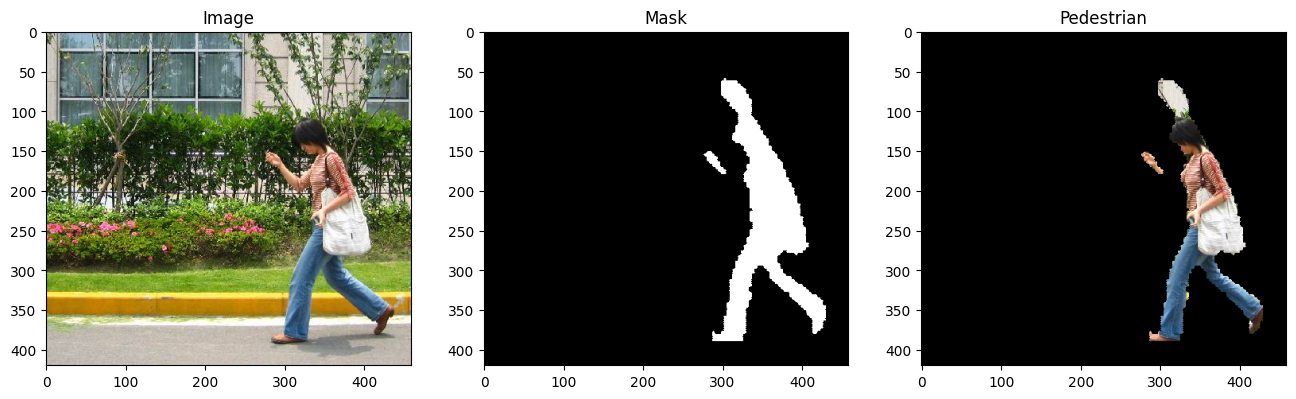

In [291]:
# Load 3 images from training dataset
idx_list = [6,8,9]

for idx in idx_list:
    train_img_path = train_img_list[idx]
    train_img = cv2.imread(train_img_path)
    train_img = cv2.cvtColor(train_img, cv2.COLOR_BGR2RGB)


    # Predict the mask
    train_mask = predict_mask(net=net,
                    img=train_img,
                    res=(128,128),
                    out_threshold=0.5)
    
    # Rescale the mask back to original image size
    train_mask = train_mask.cpu().numpy()
    train_mask = cv2.resize(train_mask, (train_img.shape[1],train_img.shape[0]))

    train_img_seg = train_img * train_mask[:,:,None]

    plt.figure(figsize = (16,48))
    plt.subplot(1,3,1)
    plt.imshow(train_img)
    plt.title('Image')
    plt.subplot(1,3,2)
    plt.imshow(train_mask,cmap='gray')
    plt.title('Mask')
    plt.subplot(1,3,3)
    plt.imshow(train_img_seg)
    plt.title('Pedestrian')

### 3 example segmentations  from the testing data

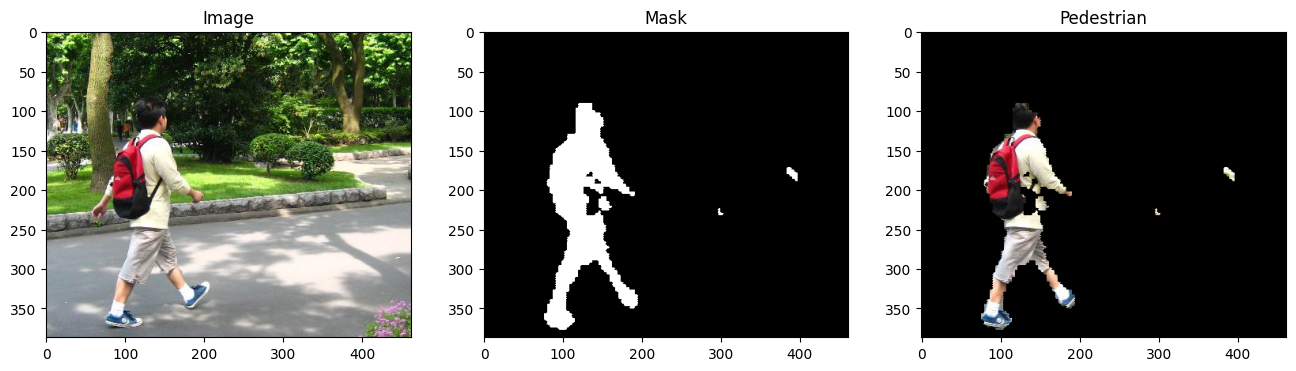

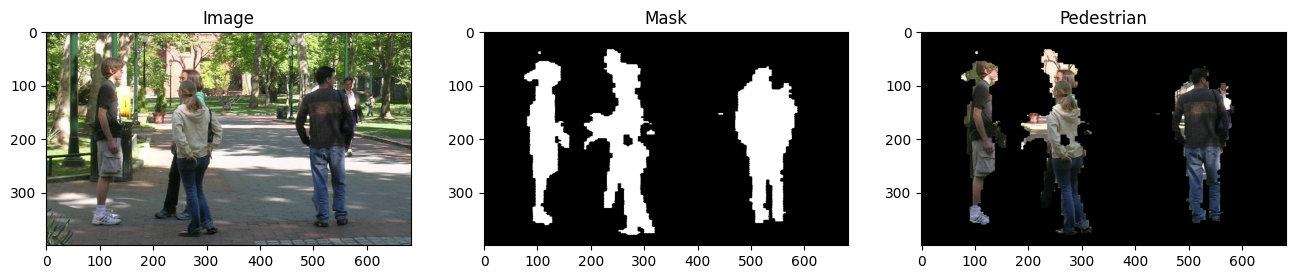

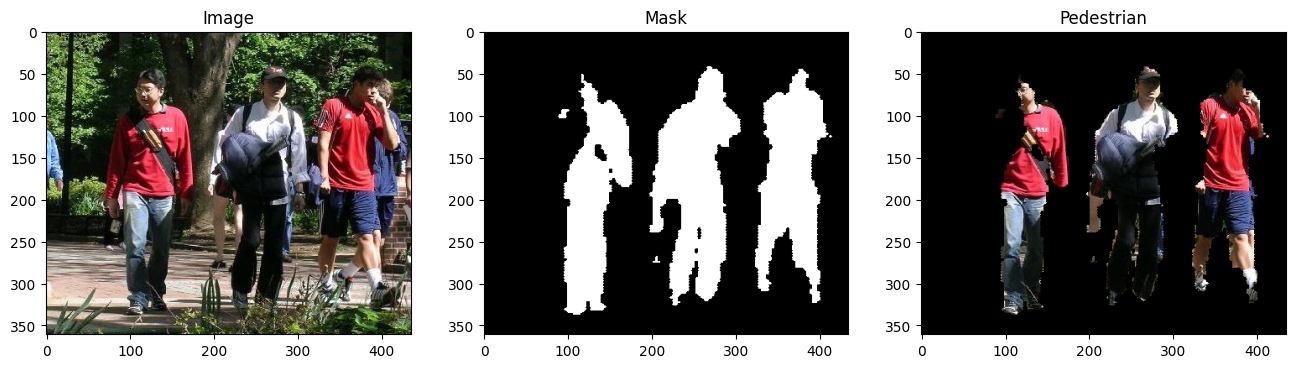

In [292]:
# Load 3 images from testing dataset
idx_list = [6,8,9]

for idx in idx_list:
    img_path = test_img_list[idx]
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    mask = predict_mask(net=net,
                    img=img,
                    res=(128,128),
                    out_threshold=0.5)
    
    mask = mask.cpu().numpy()
    mask = cv2.resize(mask, (img.shape[1],img.shape[0]))

    img_seg = img*mask[:,:,None]

    plt.figure(figsize = (16,48))
    plt.subplot(1,3,1)
    plt.imshow(img)
    plt.title('Image')
    plt.subplot(1,3,2)
    plt.imshow(mask,cmap='gray')
    plt.title('Mask')
    plt.subplot(1,3,3)
    plt.imshow(img_seg)
    plt.title('Pedestrian')

# comment: 

With the change in the number of iterations, both training loss and validation loss show a decreasing trend. Additionally, the U-net network is complex enough to capture the data. However, the dataset is small and lacks diversity, and it is expected that the model would perform significantly better with a much larger dataset. <br>

To be specific, the model identifies some objects as targets. Also, the model could not identify the whole targets, and in the other words, it has some miss detection. 






### (g) Show an example which is not from the FudanPed datase

Text(0.5, 1.0, 'Pedestrian')

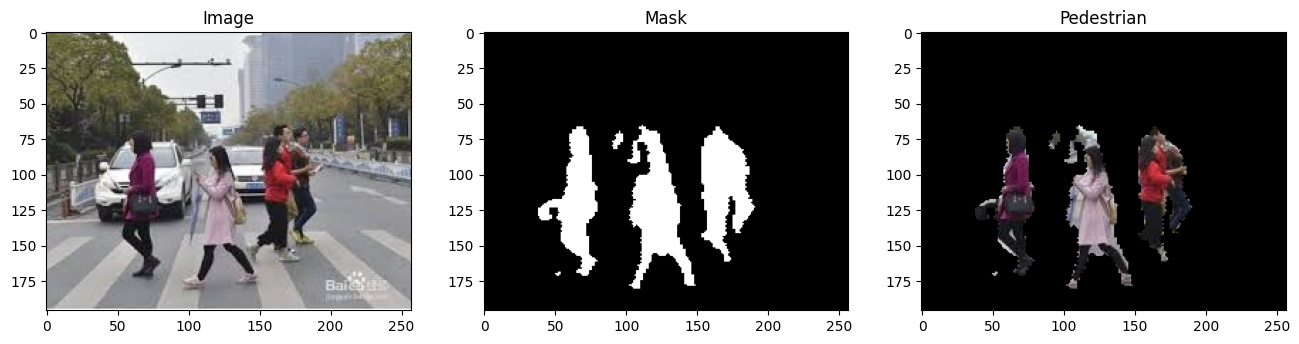

In [296]:
example_img = cv2.imread("example.jpg")
example_img = cv2.cvtColor(example_img, cv2.COLOR_BGR2RGB)


example_mask = predict_mask(net=net,
                    img=example_img,
                    res=(128,128),
                    out_threshold=0.5)
    
example_mask = example_mask.cpu().numpy()
example_mask = cv2.resize(example_mask, (example_img.shape[1],example_img.shape[0]))

img_seg = example_img * example_mask[:,:,None]

plt.figure(figsize = (16,48))
plt.subplot(1,3,1)
plt.imshow(example_img)
plt.title('Image')
plt.subplot(1,3,2)
plt.imshow(example_mask,cmap='gray')
plt.title('Mask')
plt.subplot(1,3,3)
plt.imshow(img_seg)
plt.title('Pedestrian')


# Comment
With the change in the number of iterations, both training loss and validation loss show a decreasing trend. Additionally, the U-net network is complex enough to capture the data. However, the dataset is small and lacks diversity, and it is expected that the model would perform significantly better with a much larger dataset. <br>

To be specific, for the "out-of-distribution" image, the model identifies some objects as targets. For example, the model identifies some leaves as targets. Also, the model could not identify the whole targets, and in the other words, it has some miss detection. For example, the model does not detect the whole person on the far right. <br>


